# - Project Description -

### Churn is a problem - always has been, always will be.

#### Motivation:
The business landscape is getting more competitive than ever, especially with access to information and new technology! 


- Big companies --> Retain market share.


- SMEs --> Grow market share


- Startups --> reduce burn rate and identify areas of business leakage!
.
.
.
.

**Rough intuition/hypothesis we seek answers to in this project:**
- What type of customer profile are most likely to churn? (Customer Segmentation - KMeans Clustering)
- Any strong r/s b/w tenure and churn? What's the mode tenure before a customer churns?  
- Any r/s b/w number of services used by customer and churn liklihood? The more one uses, the higher the switching costs (troublesome and inertia to change)?  

**Our workflow for this project would be as follows:**
- Univariate/Bivariate EDA
- Feature Engineering
- Feature Selection 
- Models Application & Selection
- Model Tuning (+ Oversampling/Undersampling + XGBoost)
- Conclusion

**Models to attempt**:
-Logistic
-Random forest
-Neural networks
-SVM
-(any of the above combined with fuzzy methodologies)

### 1. Exploratory Data Analysis (EDA)

In [2]:
#import relevant packages and libraries for EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()  #data looks clean for now (no null values), as expected from Kaggle :) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [6]:
df.describe()   #an overview of the numerical columns we've got.

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
#let's set out target variable clearly as a binary variable, where 'Yes' = 1, 'No' = 0
df['Churn'] = [1 if i == 'Yes' else 0 for i in df.Churn]

In [8]:
#Total Charges, like monthly charges should be a numeric data - let's inspect further
# pd.to_numeric(df['TotalCharges'])  #we see "" values at row 488

#upon inspection, seems like those with tenure 0 (new customers < 1 month) show "" under the TotalCharges column
#since the month has not ended for them, they have not been charged at the point in time, it make sense to impute 0.

df['TotalCharges'] = df['TotalCharges'].replace(" ", 0)

In [9]:
df[df.tenure==0] #checking
df.TotalCharges = pd.to_numeric(df['TotalCharges'])  #change datatype into numeric

### 1.1 Univariate Analysis 

#### 1.1.1 Continuous features- (Tenure, Monthly Charges, Total Charges)

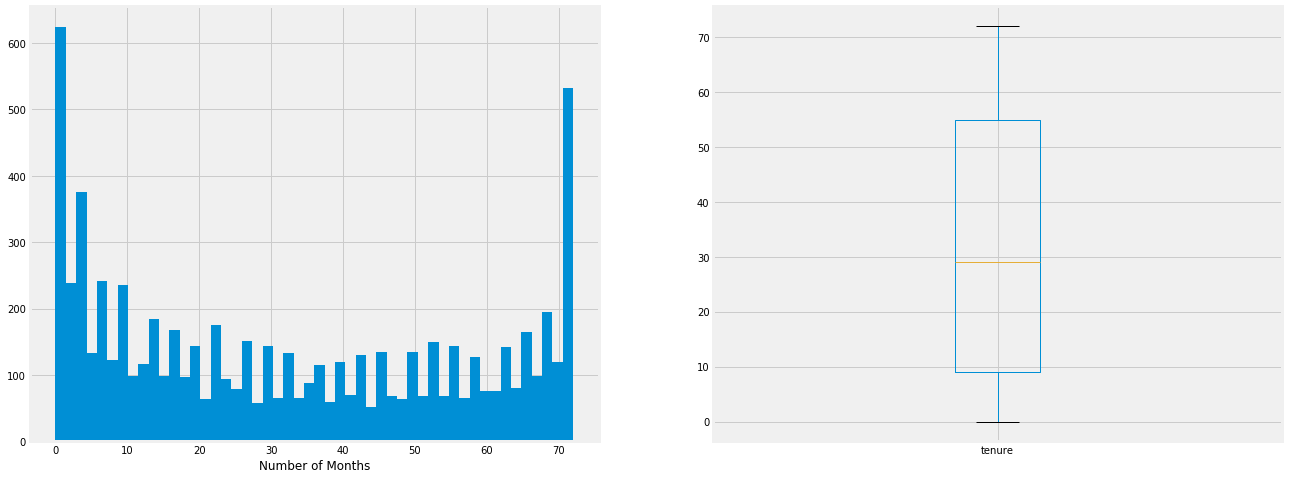

In [10]:
fig, ax = plt.subplots(1,2)
df.tenure.hist(bins=50,figsize=(20,8), ax=ax[0])
ax[0].set_xlabel("Number of Months")
df.boxplot('tenure',figsize=(20,8), ax=ax[1])
#Seems like the customers tenures are quite evenly spread out except for 2 segments. 
# --> more customers who stayed around 6 years, and those who've stayed around 1-2 months. 

#Boxplot looks reasonable - no obvious outliers

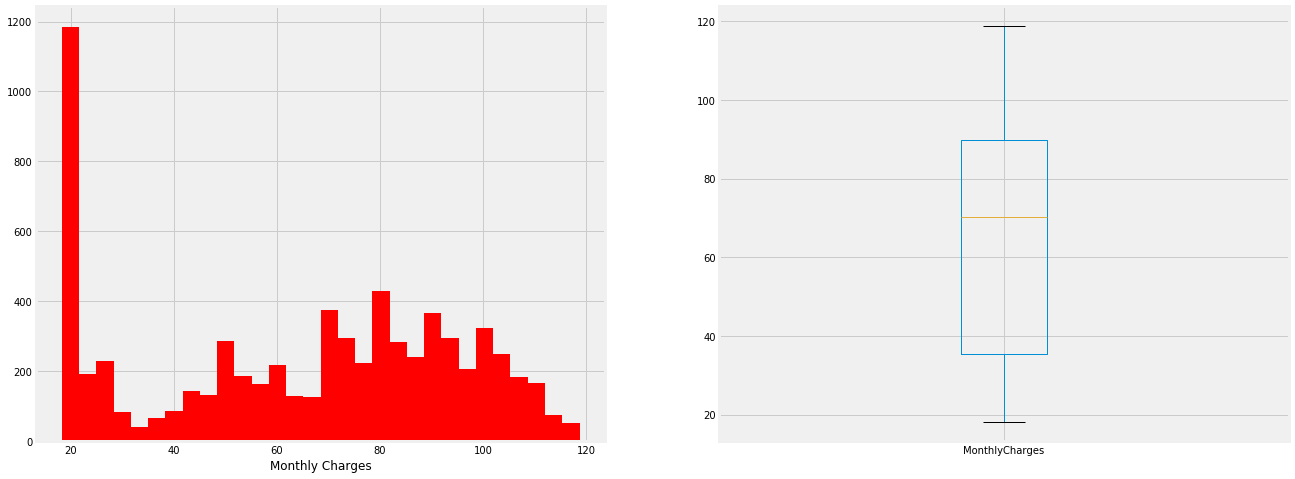

In [11]:
fig, ax = plt.subplots(1,2)
df.MonthlyCharges.hist(bins=30,figsize=(20,8), ax=ax[0],color='r')
ax[0].set_xlabel("Monthly Charges")
df.boxplot('MonthlyCharges',figsize=(20,8), ax=ax[1])

#seems like there's a huge proportion (about 15%) of customers paying $20 per month
#No obvious outliers spotted

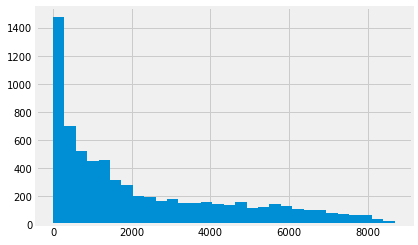

In [12]:
df.TotalCharges.hist(bins=30)

In [13]:
df[['tenure','MonthlyCharges','TotalCharges']]
df['ten_mon'] = df.MonthlyCharges * df.tenure

df[df.TotalCharges < df.ten_mon]['PaperlessBilling'].value_counts()

Yes    1924
No     1290
Name: PaperlessBilling, dtype: int64

**Good to note that:**

Total Charges is MORE and LESS than monthly charges * tenure for approx 90% of the time (45% respectively). 

Only 10% of the time Total Charges = Monthly Charges * Tenure --> Almost most of these cases have tenure of 1 month. 

-There seems to be no obvious indicators from the given features that points to whether total charge would be more or less than tenure * monthlycharge.  
- For more, we believe some services could be pay-as-you-use or more likely the customer could've exceeded his plan's limits (eg. call time, data)
- For less, we suspect there could be some form of promotion/disocunts applied to their accounts based on variety of reasons (eg. affliate marketers, period plan was bought, referral codes used, etc)

#### 1.1.2 Categorical features --> gender, seniorcitizen, partner, dependents, phone service, etc..

In [14]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [15]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ten_mon
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1936.30
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,107.70
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1903.50
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,141.40


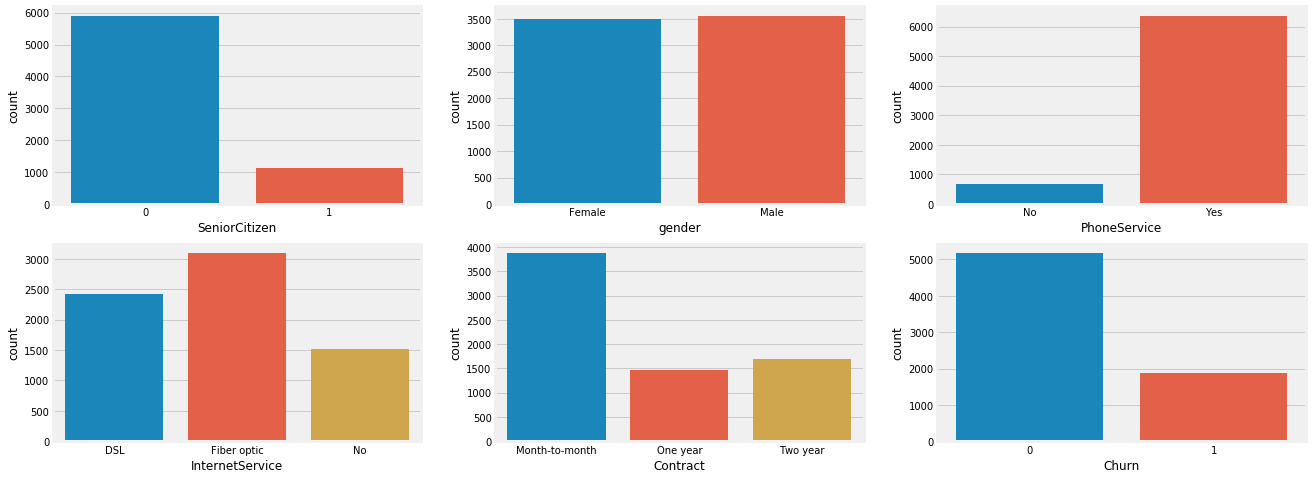

In [16]:
fig, ax = plt.subplots(2,3, figsize=(20,8))

sns.countplot(df.SeniorCitizen, ax=ax[0,0])
sns.countplot(df.gender, ax=ax[0,1])
sns.countplot(df.PhoneService, ax=ax[0,2])
sns.countplot(df.InternetService, ax=ax[1,0])
sns.countplot(df.Contract, ax=ax[1,1])
sns.countplot(df.Churn, ax=ax[1,2])


In [17]:
df[df.PhoneService == 'No'][df.InternetService == 'No']
#Logically, customers will either have a Phone, Internet service or both. Data does not show any anomaly!

C:\Users\Jit Nung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ten_mon


**It's good to note that:**
- Customers with no Internet Service will definitely not have OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. Hence we see values of "No Internet Service" in these columns.
- Customers with no Phone Service will have no MultipleLines. Hence we see values of "No Phone Service" in this column.
- We have an slightly imbalanced class situation (about 30% churn, and 70% dont)


### 1.2 Bivariate Analysis

In [18]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'ten_mon'],
      dtype='object')

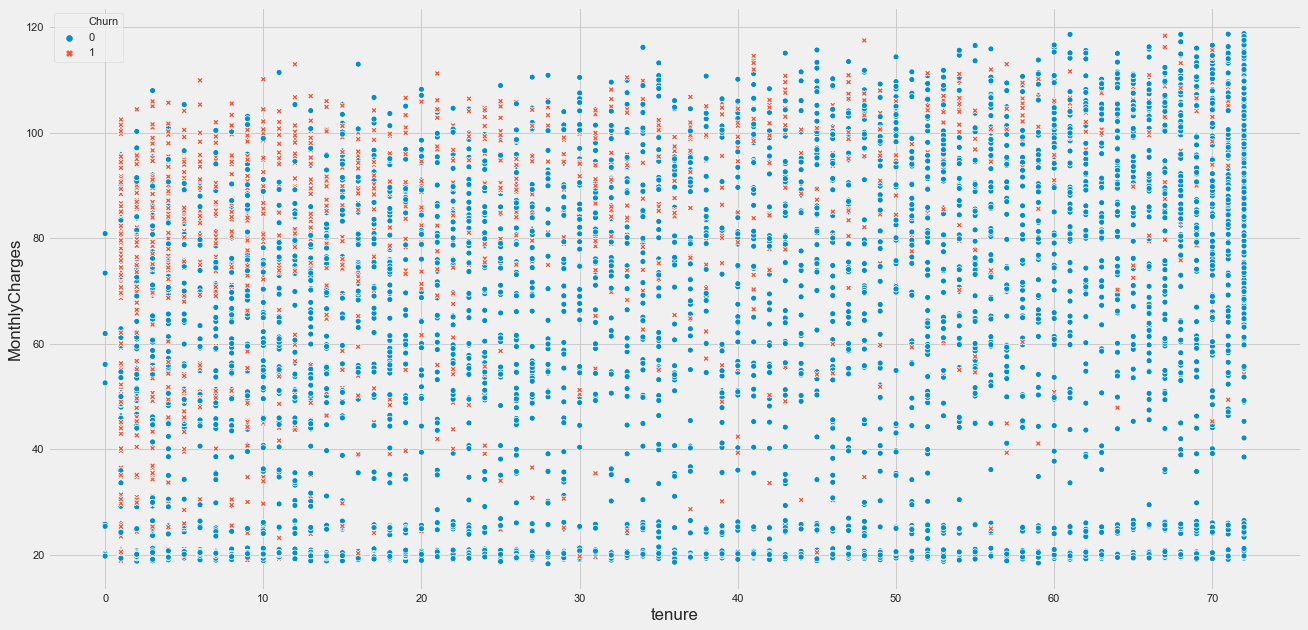

In [19]:
sns.set(rc={"figure.figsize": (20, 10)})
plt.style.use('fivethirtyeight')
sns.scatterplot( x="tenure", y="MonthlyCharges", data=df, hue='Churn',style='Churn')

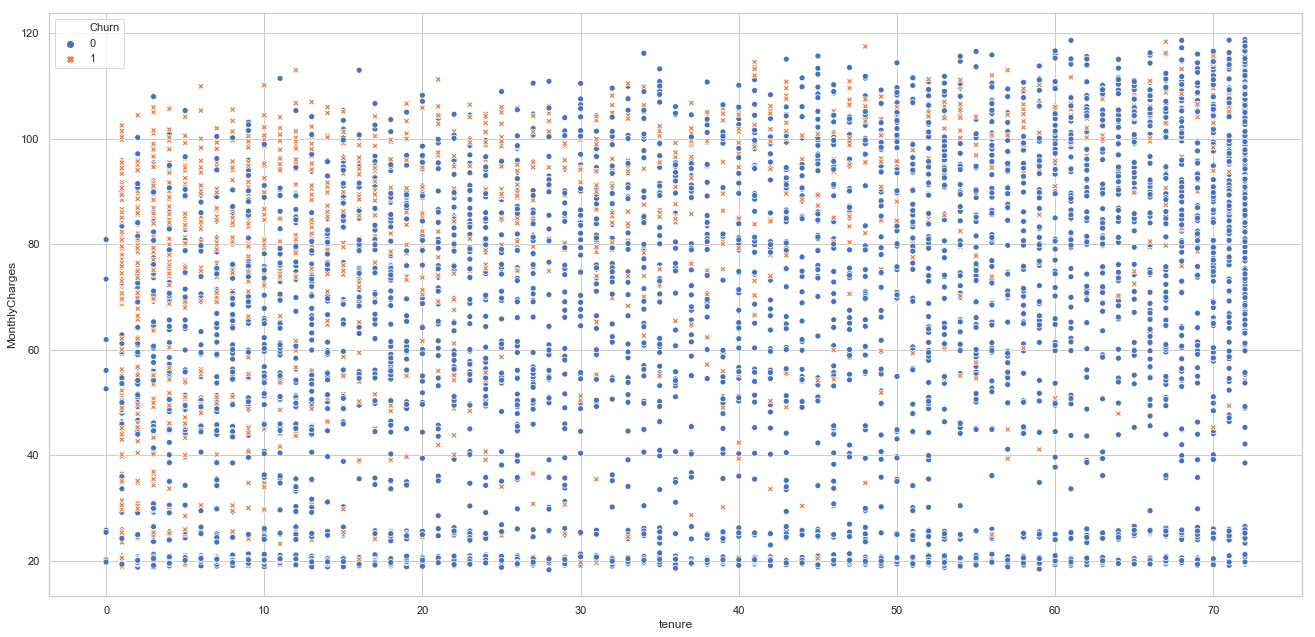

In [20]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.set_style("whitegrid")
sns.scatterplot( x="tenure", y="MonthlyCharges", data=df, hue='Churn',style='Churn')

**We see no clear correlation between tenure and monthly charges**

**We see churn happening across tenure but there's strong concentration for tenure within 20 months, especially so in first 10 months, regardless of how much they were charged.**

**Across monthly charges, churn seems to be happening more often for charges > $60.**

Text(0.5, 0, 'Churn')

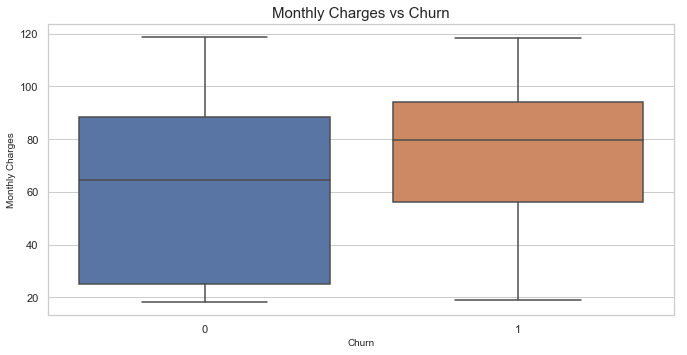

In [21]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
ax.set_title('Monthly Charges vs Churn', fontsize=15)
ax.set_ylabel('Monthly Charges', fontsize=10)
ax.set_xlabel('Churn', fontsize=10)

Text(0.5, 0, 'Churn')

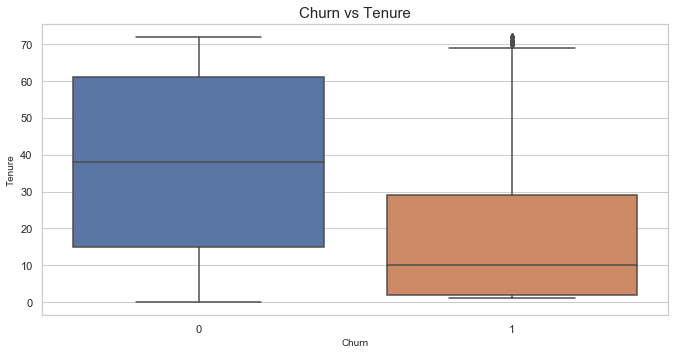

In [22]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='Churn', y = 'tenure', data=df)
ax.set_title('Churn vs Tenure', fontsize=15)
ax.set_ylabel('Tenure', fontsize = 10)
ax.set_xlabel('Churn', fontsize = 10)

**On average, it seems like churn happens when monthly charges are higher and tenure is shorter.**

Text(0.5, 0, 'Number of Online Services')

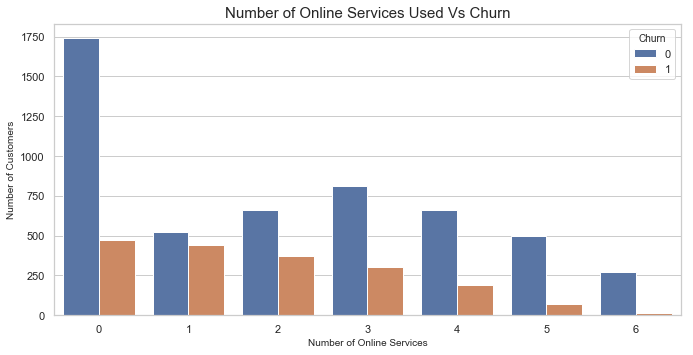

In [23]:
#count of online services used
df['Count_OnlineServices'] = (df[['OnlineSecurity', 'DeviceProtection', 'StreamingMovies', 'TechSupport',
                                  'StreamingTV', 'OnlineBackup']] == 'Yes').sum(axis=1)

plt.figure(figsize=(10,5))
ax = sns.countplot(x='Count_OnlineServices', hue='Churn', data=df)
ax.set_title('Number of Online Services Used Vs Churn', fontsize=15)
ax.set_ylabel('Number of Customers', fontsize=10)
ax.set_xlabel('Number of Online Services', fontsize=10)

**Most churn customers come from those who dont use online services at all. However, highest proportion of churn are from those who only use 1 online service. Proportion of churn decreases with more online services used.**

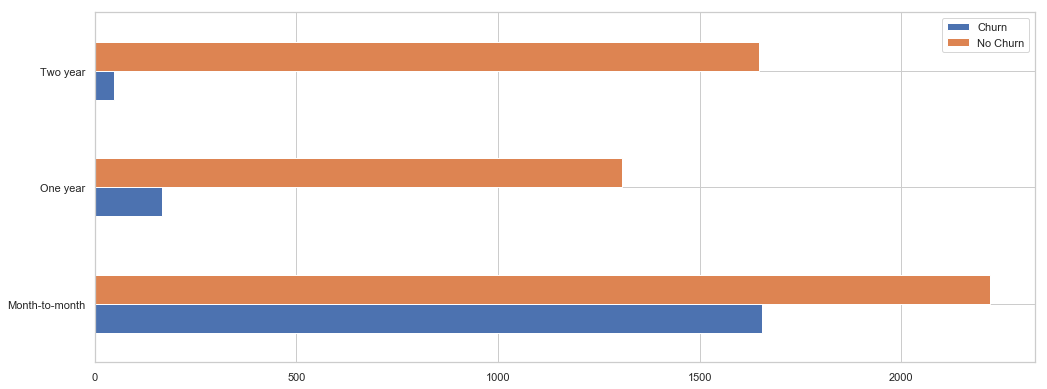

In [24]:
for c in list(df.Contract.unique()):
    df[c]=[1 if c in ctype else 0 for ctype in df['Contract']]
    
contract_churn = pd.DataFrame({'Churn': df[df['Churn']==1][list(df.Contract.unique())].sum(),
                                'No Churn': df[df['Churn']==0][list(df.Contract.unique())].sum()
                           }, index = list(df.Contract.unique()))
# print(contract_churn)
contract_churn.plot(kind='barh',figsize=(15,6))

**As expected, even with higher volumes of month-to-month contracts in general, we see a disproportionately high numbers of churn compared to one or two year contracts.**

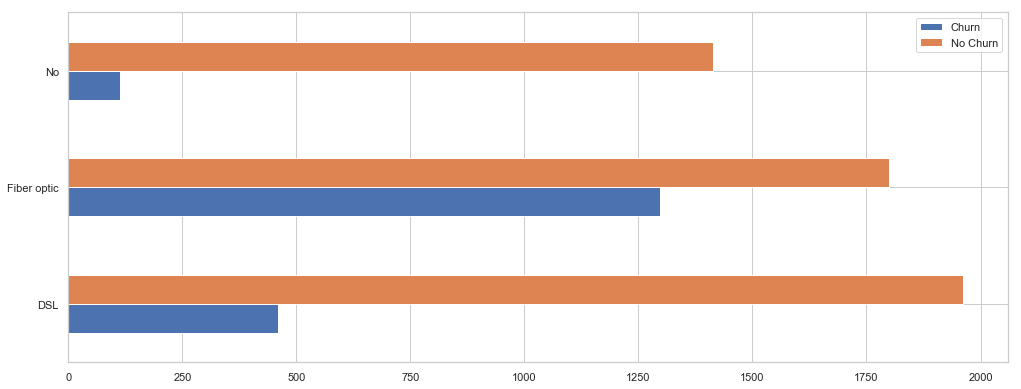

In [25]:
for i in list(df.InternetService.unique()):
    df[i]=[1 if i in itype else 0 for itype in df['InternetService']]
    
internet_churn = pd.DataFrame({'Churn': df[df['Churn']==1][list(df.InternetService.unique())].sum(),
                            'No Churn': df[df['Churn']==0][list(df.InternetService.unique())].sum()
                           }, index = list(df.InternetService.unique()))

internet_churn.plot(kind='barh',figsize=(15,6))    

**Seems like there's really high proportion of churn in 'fibre optic' internet services - cause for concern!**

,Churn,No Churn
No,170,512
Yes,1699,4662


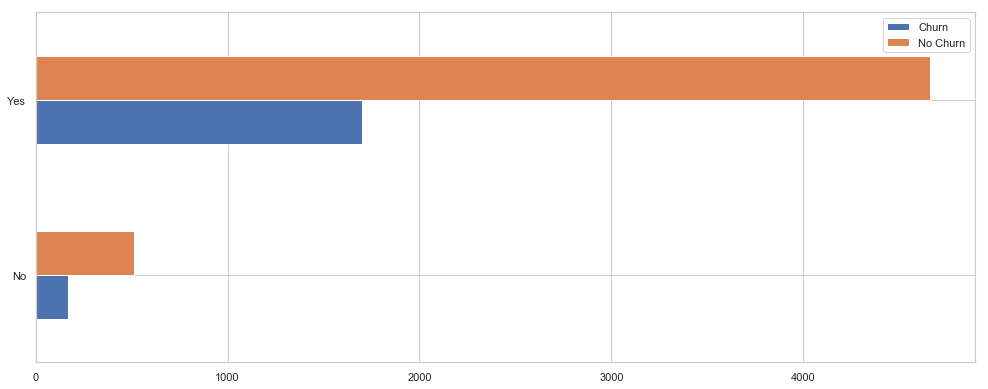

In [26]:
for i in list(df.PhoneService.unique()):
    df[i]=[1 if i in itype else 0 for itype in df['PhoneService']]
    
phone_churn = pd.DataFrame({'Churn': df[df['Churn']==1][list(df.PhoneService.unique())].sum(),
                            'No Churn': df[df['Churn']==0][list(df.PhoneService.unique())].sum()
                           }, index = list(df.PhoneService.unique()))

phone_churn.plot(kind='barh',figsize=(15,6))
phone_churn

#churn numbers seem to be proportionate across those with and without phone service (about 30%)

## 2. Feature Engineering & Preprocessing

New Features:
- (binary): Customers with both Phone and Fiber Optics
- (binary): Customers with both Phone and DSL 
- (continuous): difference between TotalCharges and MonthlyCharges * tenure

- Get dummies for all categorical features.


In [27]:
df[df.InternetService != 'No']['PhoneService'].value_counts()

Yes    4835
No      682
Name: PhoneService, dtype: int64

In [28]:
df[df.InternetService == 'Fiber optic']['PhoneService'].value_counts()

Yes    3096
Name: PhoneService, dtype: int64

In [29]:
df[df.InternetService == 'DSL']['PhoneService'].value_counts()

Yes    1739
No      682
Name: PhoneService, dtype: int64

In [30]:
dsl_ph = []
for i in range(len(df)):
    if df.iloc[i,27] == 1 and df.iloc[i,24] == 1:
        dsl_ph.append(1)
    else:
        dsl_ph.append(0)
    
df['DSL_phone'] = dsl_ph

In [31]:
Fibre_Ph = []
for i in range(len(df)):
    if df.iloc[i,27] == 1 and df.iloc[i,25] ==1:
        Fibre_Ph.append(1)
    else:
        Fibre_Ph.append(0)
    
df['Fibre_phone'] = Fibre_Ph

In [32]:
monthly_ten = df.MonthlyCharges * df.tenure
df['Charges_Diff'] = df.TotalCharges - monthly_ten

In [33]:
#convert categorical features into dummy variables
X = pd.get_dummies(df, columns = ['gender','SeniorCitizen','Partner', 'Dependents','PhoneService',
        'MultipleLines','InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']
              ,drop_first=True)

X.drop(columns=['customerID','ten_mon', 'Count_OnlineServices','Churn','Month-to-month', 'One year',
                'Two year', 'DSL', 'Fiber optic', 'No','Yes'],inplace=True)

In [34]:
X.head()

,tenure,MonthlyCharges,TotalCharges,DSL_phone,Fibre_phone,Charges_Diff,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,0.00,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,0,-46.80,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,0,0,0.45,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,0,-62.75,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,10.25,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [35]:
#standardizing ONLY the continuous variables 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_cont = X[['tenure','MonthlyCharges','TotalCharges','Charges_Diff']]
Xstd = ss.fit_transform(X_cont)
Xs_cont = pd.DataFrame(Xstd, columns=['tenure','MonthlyCharges','TotalCharges','Charges_Diff'])

C:\Users\Jit Nung\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jit Nung\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
X.drop(columns=['tenure','MonthlyCharges','TotalCharges','Charges_Diff'],inplace=True)
X = pd.concat([X,Xs_cont],axis=1)
X.head()

# putting our working dataset in place - with standardized continuous features and dummified categorical features

,DSL_phone,Fibre_phone,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Charges_Diff
0,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,-1.277445,-1.160323,-0.992611,-0.002276
1,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0.066327,-0.259629,-0.172165,-0.698725
2,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,-1.236724,-0.362660,-0.958066,0.004420
3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0.514251,-0.746535,-0.193672,-0.936084
4,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,-1.236724,0.197365,-0.938874,0.150258


### 3. Explore Cusomter Segmentation/Clustering & Predicting Customer Lifetime Value 

In [37]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [38]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'ten_mon',
       'Count_OnlineServices', 'Month-to-month', 'One year', 'Two year', 'DSL',
       'Fiber optic', 'No', 'Yes', 'DSL_phone', 'Fibre_phone', 'Charges_Diff'],
      dtype='object')

In [39]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Month-to-month,One year,Two year,DSL,Fiber optic,No,Yes,DSL_phone,Fibre_phone,Charges_Diff
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,1,0,0,1,0,1,0,0,0,0.00
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,0,1,0,1,0,0,1,0,0,-46.80
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,1,0,0,1,0,0,1,0,0,0.45
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,0,1,0,1,0,1,0,0,0,-62.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,1,0,0,0,1,0,1,0,0,10.25


In [82]:
bdf = df[['tenure','MonthlyCharges','Churn']][df.Churn ==1]
bdf.head()

,tenure,MonthlyCharges,Churn
2,2,53.85,1
4,2,70.70,1
5,8,99.65,1
8,28,104.80,1
13,49,103.70,1


In [84]:
np.mean(bdf.tenure)

17.979133226324237

In [85]:
np.mean(bdf.MonthlyCharges)

74.4413322632423

In [87]:
len(bdf)

1869

In [95]:
len(df.customerID.unique())

7043

In [96]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'ten_mon',
       'Count_OnlineServices', 'Month-to-month', 'One year', 'Two year', 'DSL',
       'Fiber optic', 'No', 'Yes', 'DSL_phone', 'Fibre_phone', 'Charges_Diff'],
      dtype='object')

In [98]:
df[df.tenure > 68][df['Two year']==1]

C:\Users\Jit Nung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Month-to-month,One year,Two year,DSL,Fiber optic,No,Yes,DSL_phone,Fibre_phone,Charges_Diff
15,3655-SNQYZ,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,...,0,0,1,0,1,0,1,0,1,80.90
17,9959-WOFKT,Male,0,No,Yes,71,Yes,Yes,Fiber optic,Yes,...,0,0,1,0,1,0,1,0,1,-193.45
28,5248-YGIJN,Male,0,Yes,No,72,Yes,Yes,DSL,Yes,...,0,0,1,1,0,0,1,0,0,-128.55
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,0,0,1,0,1,0,1,0,1,-73.90
35,6234-RAAPL,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,0,0,1,0,1,0,1,0,1,58.90
41,9489-DEDVP,Female,0,Yes,Yes,70,Yes,Yes,DSL,Yes,...,0,0,1,1,0,0,1,0,0,28.35
49,2954-PIBKO,Female,0,Yes,Yes,69,Yes,Yes,DSL,Yes,...,0,0,1,1,0,0,1,0,0,-172.25
59,5954-BDFSG,Female,0,No,No,72,Yes,Yes,Fiber optic,No,...,0,0,1,0,1,0,1,0,1,113.70
62,0526-SXDJP,Male,0,Yes,No,72,No,No phone service,DSL,Yes,...,0,0,1,1,0,1,0,0,0,-69.20
94,9848-JQJTX,Male,0,No,No,72,Yes,Yes,Fiber optic,No,...,0,0,1,0,1,0,1,0,1,194.25


In [99]:
df[['Charges_Diff','Contract']]

,Charges_Diff,Contract
0,0.00,Month-to-month
1,-46.80,One year
2,0.45,Month-to-month
3,-62.75,One year
4,10.25,Month-to-month
5,23.30,Month-to-month
6,-10.80,Month-to-month
7,4.40,Month-to-month
8,111.65,Month-to-month
9,6.65,One year


### 4. Quick comparison on how our different model fares across all features based on selected metrics

In [69]:
from sklearn.model_selection import StratifiedKFold, train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,precision_score
from sklearn.metrics import precision_recall_curve,recall_score, accuracy_score, f1_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier

In [52]:
from sklearn.model_selection import StratifiedKFold, train_test_split
y = df.Churn
#split data into train and holdout/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [53]:
def classreport_auc(estimator, X, y):
    """
    this function will take in an estimator, as well as X_test and y_test. It returns a confusion matrix,
    classification report and the AUC score.
    """
    predicted = estimator.predict(X)
    pred_proba = estimator.predict_proba(X)
    conmat = np.array(confusion_matrix(y, predicted, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['no_churn', 'churn'], columns=['pred_no_churn','pred_churn'])
    print(confusion)
    
    print(classification_report(y,predicted))
    print("Accuracy:", accuracy_score(y,predicted))
    print("AUC Score:", roc_auc_score(y, pred_proba[:,1]))

In [542]:
#for imbalanced class problem
def models_summary_imb(models,X_train,y_train):
    scores_dict = {}
    
    for model in models:
        skf = StratifiedKFold(n_splits=10,random_state=42)
        
        acc_scores = []
        pre_scores = []
        rec_scores = []
        f1_scores = []
        auc_scores = []
        for train_index, test_index in skf.split(X_train,y_train):
            
            Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
            yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
            #ADASYN oversampling tool
            upsam = ADASYN(sampling_strategy='minority', random_state=42,
              n_jobs=-1)
            X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
            model.fit(X_upsam, y_upsam)
            yfold_pred = model.predict(Xfold_test)        
            y_scores = model.predict_proba(Xfold_test)
            pos_probs = y_scores[:,1]  #we are interested in the probablity of the positive (churn) outcomes
            
            #append every fold's metric result to a list 
            auc_scores.append(roc_auc_score(yfold_test,pos_probs))
            acc_scores.append(accuracy_score(yfold_test,yfold_pred))
            pre_scores.append(precision_score(yfold_test, yfold_pred))
            rec_scores.append(recall_score(yfold_test, yfold_pred))
            f1_scores.append(f1_score(yfold_test, yfold_pred))


        scores_dict[model] = np.mean(acc_scores), np.mean(pre_scores), np.mean(rec_scores), np.mean(f1_scores), np.mean(auc_scores)
    
    df = pd.DataFrame(scores_dict)
    df.columns = ['Logistic Reg','Random Forest','Grad Boost','Linear SVM','RBF SVM','GaussianNB','AdaBoost']
    
    return df

In [545]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
gradboost = GradientBoostingClassifier()
lsvm = SVC(kernel='linear',probability=True)
rbf_svm = SVC(gamma='auto',probability=True)
gnb = GaussianNB()
adb = AdaBoostClassifier()
models = [lr,rfc,gradboost,lsvm,rbf_svm,gnb,adb]
models_summary_imb(models,X_train,y_train)
# RFC - Maxdepth 3
# Accuracy: 0.7200842391069235
# Precision: 0.48455939176237006
# Recall: 0.812738255033557
# F1 Score: 0.6067414161151475
    
# RFC- internal
# Accuracy: 0.7183111883407902
# Precision: 0.4824180403148066
# Recall: 0.8127337807606263
# F1 Score: 0.6051542036354707

# GradB - internal 
# Accuracy: 0.7852216872988799
# Precision: 0.5845330136510017
# Recall: 0.6683937360178971
# F1 Score: 0.6231633159743917

,Logistic Reg,Random Forest,Grad Boost,Linear SVM,RBF SVM,GaussianNB,AdaBoost
0,0.712102,0.736239,0.785222,0.678034,0.709092,0.670224,0.761083
1,0.477051,0.502403,0.584533,0.446281,0.472975,0.439354,0.536435
2,0.844188,0.808738,0.668394,0.841548,0.822792,0.868926,0.743906
3,0.609081,0.619440,0.623163,0.582058,0.600211,0.583339,0.622986
4,0.838960,0.838032,0.838807,0.827111,0.829905,0.817386,0.838794


**XGBoost Classifier**

In [548]:
xgb = XGBClassifier()

scores_dict = {}
acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
auc_scores =[]
skf = StratifiedKFold(n_splits=10,random_state=42)
for train_index, test_index in skf.split(X_train,y_train):
    
    Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #ADASYN oversampling tool
    upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
    X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
    X_upsam, y_upsam = np.array(X_upsam), np.array(y_upsam) 
    Xfold_test = np.array(Xfold_test)
    xgb.fit(X_upsam, y_upsam)

    y_scores = xgb.predict_proba(Xfold_test)
    pos_probs = y_scores[:,1]  #we are interested in the probablity of the positive (churn) outcomes
    yfold_pred = xgb.predict(Xfold_test)
    
    #append every fold's metric result to a list 
    auc_scores.append(roc_auc_score(yfold_test,pos_probs))    
    acc_scores.append(accuracy_score(yfold_test,yfold_pred))
    pre_scores.append(precision_score(yfold_test, yfold_pred))
    rec_scores.append(recall_score(yfold_test, yfold_pred))
    f1_scores.append(f1_score(yfold_test, yfold_pred))
scores_dict[xgb] = np.mean(acc_scores), np.mean(pre_scores), np.mean(rec_scores), np.mean(f1_scores), np.mean(auc_scores)
df = pd.DataFrame(scores_dict)
df

,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, min_child_weight=1, missing=None, n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)"
0,0.783621
1,0.580310
2,0.675069
3,0.623558
4,0.839618


## 5. Feature Selections and Model Tuning
- We further zoom in on **GradientBoost, Random Forest, Adaboost and XGBoost ** due to reasonable accuracy scores (vs baseline), high recall rates and relatively better F1 scores on average.
- Let's use RFECV to help us narrow down the important features for each respective models. 

## 5.1 Gradient Boosting - Feature Selections + Hyperparameter Tuning

In [44]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_upsam,y_upsam)

importances = list(zip(gbc.feature_importances_, X.columns))
importances.sort(reverse=True)
pd.DataFrame(importances,columns=['Coeff','Features'],index=[x for (_,x) in importances])

,Coeff,Features
Contract_Two year,0.212934,Contract_Two year
Contract_One year,0.119391,Contract_One year
tenure,0.111085,tenure
PaymentMethod_Electronic check,0.072875,PaymentMethod_Electronic check
PaperlessBilling_Yes,0.062993,PaperlessBilling_Yes
InternetService_Fiber optic,0.044188,InternetService_Fiber optic
TechSupport_Yes,0.043997,TechSupport_Yes
StreamingMovies_Yes,0.041878,StreamingMovies_Yes
OnlineSecurity_Yes,0.037368,OnlineSecurity_Yes
Dependents_Yes,0.036997,Dependents_Yes


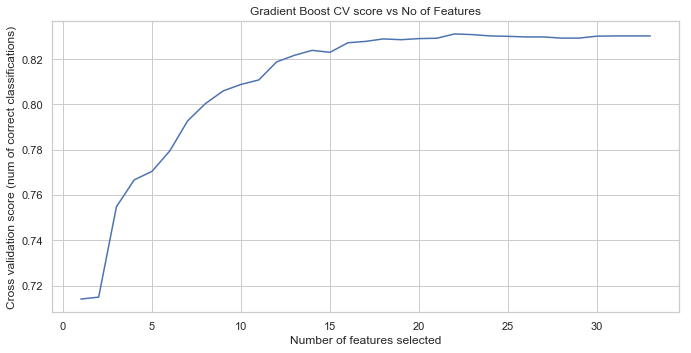

[False False  True  True  True  True False False  True  True False  True
  True False  True False  True False  True False  True False  True  True
  True  True  True  True False  True  True  True  True]
[12 11  1  1  1  1  4  7  1  1  6  1  1  5  1  3  1  8  1  9  1 10  1  1
  1  1  1  1  2  1  1  1  1]
num of features: 22


array(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff'], dtype='<U37')

In [62]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

gbc = GradientBoostingClassifier(random_state=42)
gbc_rfecv = RFECV(estimator=gbc, step=1, cv=10, scoring='f1')
gbc_rfecv.fit(X_upsam,y_upsam)

plt.figure(figsize=(10,5))
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(gbc_rfecv.grid_scores_) + 1), gbc_rfecv.grid_scores_)
plt.show()

#ideal num of features for GBC seems to be around 20, thereafter it flattens out.

print(gbc_rfecv.support_) #list of our final features in boolean
print(gbc_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[gbc_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

In [49]:
print(gbc_rfecv.support_) #list of our final features in boolean
print(gbc_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[gbc_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

[False False  True  True  True  True False False  True  True False  True
  True False  True False  True False  True False  True False  True  True
  True  True  True  True False  True  True  True  True]
[12 11  1  1  1  1  4  7  1  1  6  1  1  5  1  3  1  8  1  9  1 10  1  1
  1  1  1  1  2  1  1  1  1]
num of features: 22


array(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff'], dtype='<U37')

In [50]:
XGrad1_train = X_train[['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff']]

acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
skf = StratifiedKFold(n_splits=10,random_state=42)

for train_index, test_index in skf.split(XGrad1_train,y_train):

    Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    #ADASYN oversampling tool
    upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
    X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
    gbc.fit(X_upsam, y_upsam)
    yfold_pred = gbc.predict(Xfold_test)
    
    acc_scores.append(accuracy_score(yfold_test,yfold_pred))
    pre_scores.append(precision_score(yfold_test, yfold_pred))
    rec_scores.append(recall_score(yfold_test, yfold_pred))
    f1_scores.append(f1_score(yfold_test, yfold_pred))

print("Accuracy:", np.mean(acc_scores))
print("Precision:", np.mean(pre_scores))
print("Recall:", np.mean(rec_scores))
print("F1 Score:", np.mean(f1_scores))

Accuracy: 0.7857542309295316
Precision: 0.5867457866428457
Recall: 0.6590380313199105
F1 Score: 0.6203295799063372


#### Let's score it on our holdout set. Then proceed with hyperparameter tuning.

In [54]:
XGrad1_train = X_train[['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff']]

XGrad1_test = X_test[['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff']]

upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(XGrad1_train, y_train)
abc = AdaBoostClassifier(random_state=42)
abc.fit(X_upsam,y_upsam)

classreport_auc(abc,XGrad1_test,y_test)

          pred_no_churn  pred_churn
no_churn            772         264
churn                81         292
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1036
           1       0.53      0.78      0.63       373

   micro avg       0.76      0.76      0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

Accuracy: 0.7551454932576295
AUC Score: 0.8549522808906187


### Order of Tuning:
- optimal n_estimators (holding learning rate at default)
- Max depth and min_samples_split
- min_samples_leaf
- max features
- sub samples
- n_estimators * 2, learning rate * 0.5

In [595]:
#optimize based on best f1 scores
def gbc_gridsearch(X,y):
    """
    Gridsearch for GradientBoost hyperparameters
    INPUT: X_train and y_train
    OUTPUT: the model fitted with the best estimator
    """
    gbc = GradientBoostingClassifier(n_estimators = 130, learning_rate=0.1, min_samples_split=400, max_depth=5,
            min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=42)

    gbc_params = {'n_estimators':[260], 'learning_rate':[0.05]
                 }
    
    
    grid_gbc = GridSearchCV(gbc, param_grid=gbc_params,cv=10,n_jobs=-1,verbose=1,scoring='f1')
    grid_gbc.fit(X,y)
    
    print('best score: ', grid_gbc.best_score_)
    print('best parameters: ', grid_gbc.best_params_)
    
    return grid_gbc.best_estimator_

In [596]:
optimal_gbc = gbc_gridsearch(X_upsam,y_upsam)
optimal_gbc

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


best score:  0.8346362919871024
best parameters:  {'learning_rate': 0.05, 'n_estimators': 260}


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=400,
              min_weight_fraction_leaf=0.0, n_estimators=260,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [598]:
classreport_auc(optimal_gbc,XGrad1_test,y_test)

          pred_no_churn  pred_churn
no_churn            871         165
churn               123         250
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1036
           1       0.60      0.67      0.63       373

   micro avg       0.80      0.80      0.80      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.80      0.80      0.80      1409

Accuracy: 0.7955997161107168
AUC Score: 0.8536803751280964


## 5.2 XGBoost 

In [600]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

xgb = XGBClassifier(random_state=42)
xgb.fit(X_upsam,y_upsam)

importances = list(zip(xgb.feature_importances_, X.columns))
importances.sort(reverse=True)
pd.DataFrame(importances,columns=['Coeff','Features'],index=[x for (_,x) in importances])

,Coeff,Features
Contract_Two year,0.190751,Contract_Two year
Contract_One year,0.100370,Contract_One year
PaperlessBilling_Yes,0.058767,PaperlessBilling_Yes
Dependents_Yes,0.058255,Dependents_Yes
PaymentMethod_Electronic check,0.057788,PaymentMethod_Electronic check
StreamingMovies_Yes,0.056491,StreamingMovies_Yes
OnlineSecurity_Yes,0.054200,OnlineSecurity_Yes
TechSupport_Yes,0.044298,TechSupport_Yes
OnlineBackup_Yes,0.037080,OnlineBackup_Yes
StreamingTV_Yes,0.036037,StreamingTV_Yes


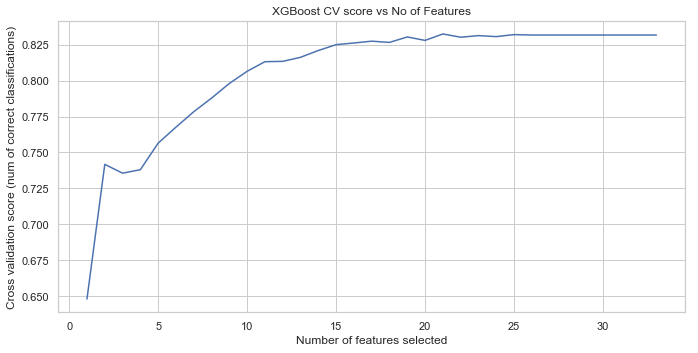

[False False  True  True  True  True False False  True  True False False
  True False  True False  True False  True False  True False  True  True
  True  True  True  True False  True  True  True  True]
[ 6  5  1  1  1  1  4 10  1  1  2  8  1  7  1 12  1  9  1 11  1 13  1  1
  1  1  1  1  3  1  1  1  1]
num of features: 21


array(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff'], dtype='<U37')

In [63]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

xgb = XGBClassifier(random_state=42)
xgb_rfecv = RFECV(estimator=xgb, step=1, cv=10, scoring='f1')
xgb_rfecv.fit(X_upsam,y_upsam)

plt.figure(figsize=(10,5))
plt.title('XGBoost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(xgb_rfecv.grid_scores_) + 1), xgb_rfecv.grid_scores_)
plt.show()

#ideal num of features for GBC seems to be around 20, thereafter it flattens out.
print(xgb_rfecv.support_) #list of our final features in boolean
print(xgb_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[xgb_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

In [65]:
X_xgb_train = X_train[['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff']]

X_xgb_test = X_test[['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Charges_Diff']]

upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_xgb_train, y_train)

#change to array
X_upsam, y_upsam = np.array(X_upsam), np.array(y_upsam)  
X_xgb_test = np.array(X_xgb_test)

xgb = XGBClassifier(random_state=42)
xgb.fit(X_upsam,y_upsam)

classreport_auc(xgb,X_xgb_test,y_test)

          pred_no_churn  pred_churn
no_churn            832         204
churn               103         270
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1036
           1       0.57      0.72      0.64       373

   micro avg       0.78      0.78      0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.81      0.78      0.79      1409

Accuracy: 0.7821149751596878
AUC Score: 0.8534125373937707


f1=0.638 auc=0.681 ap=0.681


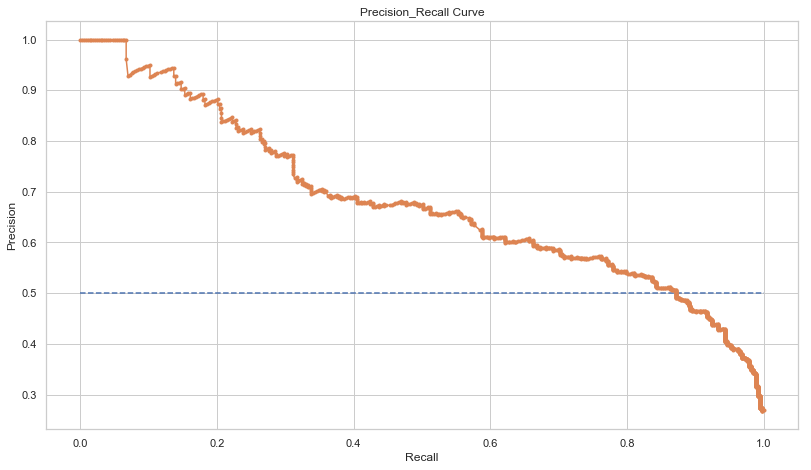

In [78]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

probs = xgb.predict_proba(X_xgb_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = xgb.predict(X_xgb_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill

plt.figure(figsize=(12,7))
plt.title('Precision_Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

### Order of Tuning:
- num of estimators (w fixed learning rate)
- max_depth and min_child_weight

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## 5.3 Random Forest 

Since RFC has inherent feature selection characteristics - let's see what it gives us


In [407]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

rfc = RandomForestClassifier(n_estimators = 100, max_depth=3)
rfc.fit(X_upsam,y_upsam)

importances = list(zip(rfc.feature_importances_, X.columns))
importances.sort(reverse=True)
pd.DataFrame(importances,columns=['Coeff','Features'],index=[x for (_,x) in importances])


,Coeff,Features
Contract_Two year,0.177147,Contract_Two year
tenure,0.138117,tenure
InternetService_Fiber optic,0.109941,InternetService_Fiber optic
PaymentMethod_Electronic check,0.095844,PaymentMethod_Electronic check
OnlineSecurity_Yes,0.072210,OnlineSecurity_Yes
TotalCharges,0.054285,TotalCharges
PaperlessBilling_Yes,0.047038,PaperlessBilling_Yes
TechSupport_Yes,0.038814,TechSupport_Yes
Dependents_Yes,0.030200,Dependents_Yes
Contract_One year,0.025671,Contract_One year


In [412]:
X2 = X_train[['Contract_Two year','tenure', 'InternetService_Fiber optic','PaymentMethod_Electronic check',
              'OnlineSecurity_Yes','TotalCharges','PaperlessBilling_Yes','TechSupport_Yes','Dependents_Yes',
              'Contract_One year','InternetService_No','TechSupport_No internet service']]

acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
skf = StratifiedKFold(n_splits=10,random_state=42)

for train_index, test_index in skf.split(X2,y_train):

    Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    #ADASYN oversampling tool
    upsam = ADASYN(sampling_strategy='minority', random_state=42,
      n_jobs=-1)
    X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
    rfc.fit(X_upsam, y_upsam)
    yfold_pred = rfc.predict(Xfold_test)
    acc_scores.append(accuracy_score(yfold_test,yfold_pred))
    pre_scores.append(precision_score(yfold_test, yfold_pred))
    rec_scores.append(recall_score(yfold_test, yfold_pred))
    f1_scores.append(f1_score(yfold_test, yfold_pred))

print("Accuracy:", np.mean(acc_scores))
print("Precision:", np.mean(pre_scores))
print("Recall:", np.mean(rec_scores))
print("F1 Score:", np.mean(f1_scores))

Accuracy: 0.7183111883407902
Precision: 0.4824180403148066
Recall: 0.8127337807606263
F1 Score: 0.6051542036354707


**RFECV; RFC Max depth = 3**

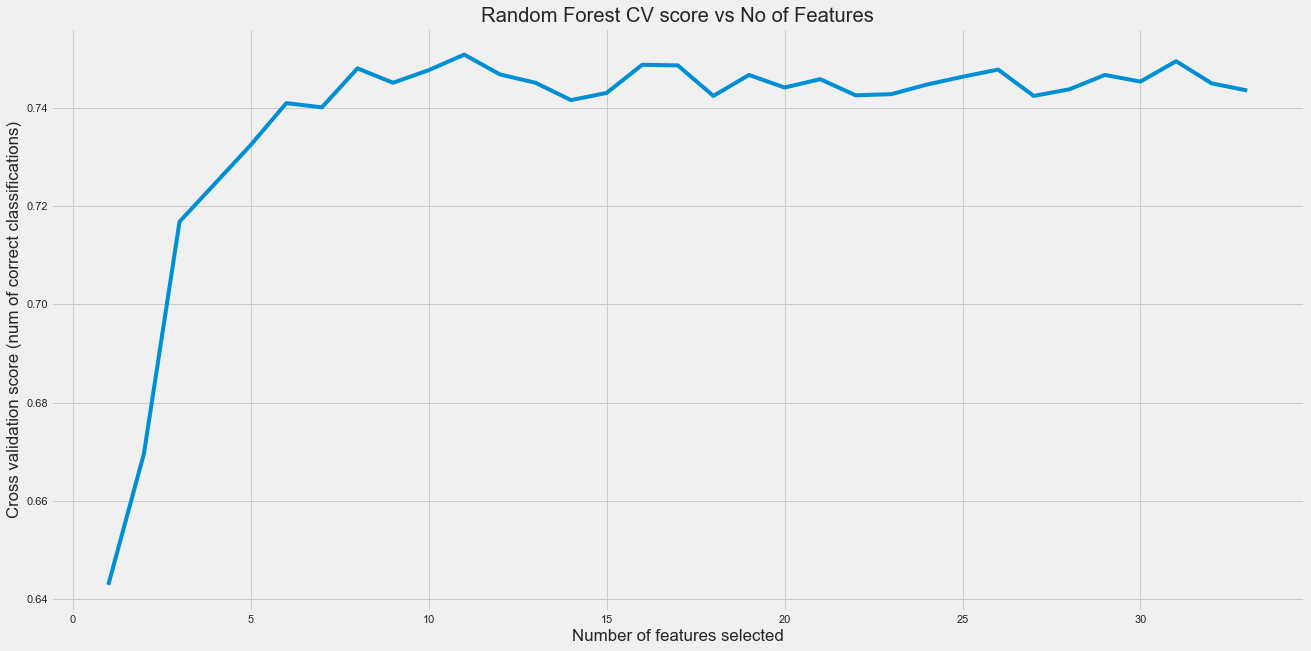

In [553]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

rfc = RandomForestClassifier(n_estimators = 100, max_depth=3)
rfc_rfecv = RFECV(estimator=rfc, step=1, cv=10, scoring='accuracy')
rfc_rfecv.fit(X_upsam,y_upsam)
plt.figure()
plt.title('Random Forest CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(rfc_rfecv.grid_scores_) + 1), rfc_rfecv.grid_scores_)
plt.show()

#ideal num of features for RFC seems to be around 12 as it peaks and slightly declines from there

In [384]:
print(rfc_rfecv.support_) #list of our final features in boolean
print(rfc_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[rfc_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

[False False False False False False False False False  True False  True
  True False False  True False False  True False False False False  True
  True  True False  True False  True False  True False]
[15 22 21 19  8  9 20 23 13  1  2  1  1  7 11  1 14  5  1  4 17  6 16  1
  1  1 12  1 18  1  3  1 10]
num of features: 11


array(['InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'DeviceProtection_No internet service', 'TechSupport_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'tenure', 'TotalCharges'],
      dtype='<U37')

In [388]:
X2 = X_train[['InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'DeviceProtection_No internet service', 'TechSupport_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'tenure', 'TotalCharges']]

acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
skf = StratifiedKFold(n_splits=10,random_state=42)

for train_index, test_index in skf.split(X2,y_train):

    Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    #ADASYN oversampling tool
    upsam = ADASYN(sampling_strategy='minority', random_state=42,
      n_jobs=-1)
    X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
    rfc.fit(X_upsam, y_upsam)
    yfold_pred = rfc.predict(Xfold_test)
    acc_scores.append(accuracy_score(yfold_test,yfold_pred))
    pre_scores.append(precision_score(yfold_test, yfold_pred))
    rec_scores.append(recall_score(yfold_test, yfold_pred))
    f1_scores.append(f1_score(yfold_test, yfold_pred))

print("Accuracy:", np.mean(acc_scores))
print("Precision:", np.mean(pre_scores))
print("Recall:", np.mean(rec_scores))
print("F1 Score:", np.mean(f1_scores))

Accuracy: 0.7200842391069235
Precision: 0.48455939176237006
Recall: 0.812738255033557
F1 Score: 0.6067414161151475


**RFC Max depth = 5**

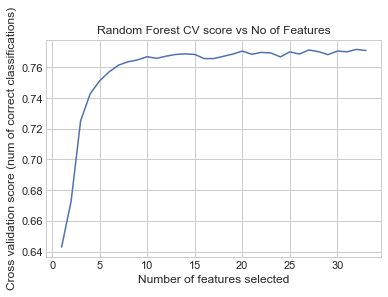

In [391]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

rfc = RandomForestClassifier(n_estimators = 100, max_depth=5)
rfc_rfecv = RFECV(estimator=rfc, step=1, cv=10, scoring='accuracy')
rfc_rfecv.fit(X_upsam,y_upsam)
plt.figure()
plt.title('Random Forest CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(rfc_rfecv.grid_scores_) + 1), rfc_rfecv.grid_scores_)
plt.show()
#ideal num of features for RFC seems to be around 25. But from 12 features onwards, CV scores improvement are marginal. 

In [392]:
print(rfc_rfecv.support_) #list of our final features in boolean
print(rfc_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[rfc_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

#32 features selected. There's almost all the features! The fact that gender and senior citize are included is surprising
#shows that RFC is showing signs of overfitting.

#we will not use the features from this run

[ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
num of features: 32


array(['DSL_phone', 'Fibre_phone', 'gender_Male', 'SeniorCitizen_1',
       'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure', 'MonthlyCharges', 'TotalCharges', 'Charges_Diff'],
      dtype='<U37')

**Features selected from RFECV - RFC (max depth=3) yielded best results on our training set. Let's put it to test.**

In [449]:
X2_train = X_train[['InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'DeviceProtection_No internet service', 'TechSupport_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'tenure', 'TotalCharges']]

X2_test = X_test[['InternetService_Fiber optic',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'DeviceProtection_No internet service', 'TechSupport_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'tenure', 'TotalCharges']]


upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X2_train, y_train)

rfc = RandomForestClassifier(n_estimators = 100, max_depth=3,random_state=42)
rfc.fit(X_upsam,y_upsam)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [421]:
classreport_auc(rfc,X2_test,y_test)

          pred_no_churn  pred_churn
no_churn            664         372
churn                35         338
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1036
           1       0.48      0.91      0.62       373

   micro avg       0.71      0.71      0.71      1409
   macro avg       0.71      0.77      0.69      1409
weighted avg       0.82      0.71      0.73      1409

Accuracy: 0.7111426543647977
AUC Score: 0.8602715124162846


In [462]:
def rfc_gridsearch(X,y):
    """
    Gridsearch for Random Forest hyperparameters
    INPUT: X_train, y_train and scoring type
    OUTPUT: the model fitted with the best estimator
    """
    rfc = RandomForestClassifier()

    rfc_params = {
        'n_estimators':[100,200,300],
        'min_samples_split':range(2,8),
        'max_depth': range(1,10)
    }

    grid_rfc = GridSearchCV(rfc,param_grid=rfc_params,cv=10,n_jobs=-1,verbose=1,scoring='recall')
    grid_rfc.fit(X,y)
    
    print('best score: ', grid_rfc.best_score_)
    print('best parameters: ', grid_rfc.best_params_)
    
    return grid_rfc.best_estimator_

In [450]:
#optimized based on accuracy
optimal_rfc = rfc_gridsearch(X_upsam,y_upsam)
classreport_auc(optimal_rfc,X2_test,y_test)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  4.4min finished


best score:  0.7664778889022774
best parameters:  {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 200}
          pred_no_churn  pred_churn
no_churn            718         318
churn                53         320
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1036
           1       0.50      0.86      0.63       373

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.72      0.78      0.71      1409
weighted avg       0.82      0.74      0.75      1409

Accuracy: 0.7366926898509581
AUC Score: 0.860422898961773


In [463]:
#optimized based on recall
optimal_rfc = rfc_gridsearch(X_upsam,y_upsam)
classreport_auc(optimal_rfc,X2_test,y_test)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  4.3min finished


best score:  0.8373056615558258
best parameters:  {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 100}
          pred_no_churn  pred_churn
no_churn            712         324
churn                51         322
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1036
           1       0.50      0.86      0.63       373

   micro avg       0.73      0.73      0.73      1409
   macro avg       0.72      0.78      0.71      1409
weighted avg       0.82      0.73      0.75      1409

Accuracy: 0.7338537970191625
AUC Score: 0.8592273334230439


### 5.3 AdaBoost Feature Selection & Hyperparameter Tuning

In [427]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_upsam,y_upsam)

importances = list(zip(adc.feature_importances_, X.columns))
importances.sort(reverse=True)
pd.DataFrame(importances,columns=['Coeff','Features'],index=[x for (_,x) in importances])

,Coeff,Features
TechSupport_Yes,0.12,TechSupport_Yes
PaperlessBilling_Yes,0.12,PaperlessBilling_Yes
Dependents_Yes,0.12,Dependents_Yes
OnlineSecurity_Yes,0.10,OnlineSecurity_Yes
OnlineBackup_Yes,0.10,OnlineBackup_Yes
tenure,0.08,tenure
Partner_Yes,0.08,Partner_Yes
MultipleLines_Yes,0.06,MultipleLines_Yes
StreamingMovies_Yes,0.04,StreamingMovies_Yes
Contract_Two year,0.04,Contract_Two year


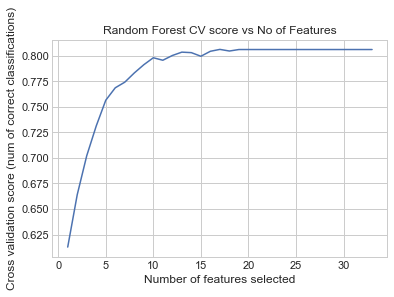

In [432]:
upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train, y_train)

abc = AdaBoostClassifier(random_state=42)
abc_rfecv = RFECV(estimator=adc, step=1, cv=10, scoring='accuracy')
abc_rfecv.fit(X_upsam,y_upsam)
plt.figure()
plt.title('Random Forest CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (num of correct classifications)")
plt.plot(range(1, len(abc_rfecv.grid_scores_) + 1), abc_rfecv.grid_scores_)
plt.show()
#ideal num of features for ABC seems to be around 17, which flattens out thereafter.

In [433]:
print(abc_rfecv.support_) #list of our final features in boolean
print(abc_rfecv.ranking_) #rank features, where 4 is removed, followed by 3 then 2. Keep the Rank 1 features!
rfecv_columns = np.array(list(X.columns))[abc_rfecv.support_]
print("num of features:", len(rfecv_columns))
rfecv_columns

[ True  True False False  True  True  True False  True  True False False
  True False  True False False False  True False  True False  True  True
  True  True False  True False  True False False False]
[ 1  1 10  9  1  1  1  6  1  1  8  5  1 12  1 16 17 15  1  2  1  3  1  1
  1  1  7  1  4  1 11 13 14]
num of features: 17


array(['DSL_phone', 'Fibre_phone', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'tenure'],
      dtype='<U37')

In [435]:
X3 = X_train[['DSL_phone', 'Fibre_phone', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'tenure']]

acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
skf = StratifiedKFold(n_splits=10,random_state=42)

for train_index, test_index in skf.split(X3,y_train):

    Xfold_train, Xfold_test = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    yfold_train, yfold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    #ADASYN oversampling tool
    upsam = ADASYN(sampling_strategy='minority', random_state=42,n_jobs=-1)
    X_upsam, y_upsam = upsam.fit_sample(Xfold_train, yfold_train)
    
    abc.fit(X_upsam, y_upsam)
    yfold_pred = abc.predict(Xfold_test)
    acc_scores.append(accuracy_score(yfold_test,yfold_pred))
    pre_scores.append(precision_score(yfold_test, yfold_pred))
    rec_scores.append(recall_score(yfold_test, yfold_pred))
    f1_scores.append(f1_score(yfold_test, yfold_pred))

print("Accuracy:", np.mean(acc_scores))
print("Precision:", np.mean(pre_scores))
print("Recall:", np.mean(rec_scores))
print("F1 Score:", np.mean(f1_scores))

Accuracy: 0.761083299117038
Precision: 0.5364351690847139
Recall: 0.7439060402684563
F1 Score: 0.6229858831508426


**Scores are same as before when all features were used as expected, as weak features' coefficients are reduced to 0. Let's proceed to testing with our holdout set!**

In [437]:
X_train_ada = X_train[['DSL_phone', 'Fibre_phone', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'tenure']]

X_test_ada = X_test[['DSL_phone', 'Fibre_phone', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'tenure']]


upsam = ADASYN(sampling_strategy='minority', random_state=42, n_jobs=-1)
X_upsam, y_upsam = upsam.fit_sample(X_train_ada, y_train)

abc = AdaBoostClassifier(random_state=42)
abc.fit(X_upsam,y_upsam)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)

In [441]:
classreport_auc(abc,X_test_ada,y_test)

          pred_no_churn  pred_churn
no_churn            760         276
churn                71         302
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1036
           1       0.52      0.81      0.64       373

   micro avg       0.75      0.75      0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409

Accuracy: 0.7537260468417317
AUC Score: 0.8561711366671152


**Gridsearch on Adaboost Hyperparameters**

In [452]:
np.linspace(0.01,0.05,0.1,0.5,1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [458]:
def abc_gridsearch(X,y):
    """
    Gridsearch for AdaBoost hyperparameters
    INPUT: X_train and y_train
    OUTPUT: the model fitted with the best estimator
    """
    abc = AdaBoostClassifier(random_state=42)

    abc_params = {'n_estimators': [50,100,200,300],
              "learning_rate" :   [0.01,0.05,0.1,0.5,1]
              }
    
    grid_abc = GridSearchCV(abc,param_grid=abc_params,cv=10,n_jobs=-1,verbose=1,scoring='recall')
    grid_abc.fit(X,y)
    
    print('best score: ', grid_abc.best_score_)
    print('best parameters: ', grid_abc.best_params_)
    
    return grid_abc.best_estimator_

In [460]:
#based on optimizing recall
optimal_abc = abc_gridsearch(X_train_ada,y_train)
classreport_auc(optimal_abc,X_test_ada,y_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.2s


best score:  0.5173558905304088
best parameters:  {'learning_rate': 1, 'n_estimators': 50}
          pred_no_churn  pred_churn
no_churn            945          91
churn               161         212
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.70      0.57      0.63       373

   micro avg       0.82      0.82      0.82      1409
   macro avg       0.78      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Accuracy: 0.8211497515968772
AUC Score: 0.8609753951577007


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.0s finished


In [457]:
#optimizing accuracy
classreport_auc(optimal_abc,X_test_ada,y_test)

          pred_no_churn  pred_churn
no_churn            958          78
churn               185         188
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.71      0.50      0.59       373

   micro avg       0.81      0.81      0.81      1409
   macro avg       0.77      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Accuracy: 0.8133427963094393
AUC Score: 0.859721604024553
